# Movies Reviews classification

In this notebook we're going to use the [*Large Movie Review Dataset*](http://ai.stanford.edu/~amaas/data/sentiment/) to train a model that will predict whether a movie review is positive or negative.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(52)

In [2]:
!wget -nv http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -P datasets/
!tar -xf datasets/aclImdb_v1.tar.gz -C datasets/

2020-09-18 12:10:39 URL:http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz [84125825/84125825] -> "datasets/aclImdb_v1.tar.gz" [1]


Now let's prepare some function to quickly load downloaded dataset:

In [3]:
import itertools

def load_from_subdir(path, label):
    X = []
    files = os.listdir(path)
    if '.ipynb_checkpoints' in files:
        files.remove('.ipynb_checkpoints') # whatever

    total = len(files)
    for i, file in enumerate(files):
        with open(os.path.join(path, file), encoding="utf8") as review:
            X.append(review.read())
        print(f'\r{i+1}/{total} files read', end='')

    y = [label] * len(X)
    print('')
    return X, y

def mix_and_shuffle(Xs, ys):
    lengths = [len(X) for X in Xs]
    assert all(len_X == len(y) for (len_X, y) in zip(lengths, ys)), "Different lists lengths."
    
    X_noshuffled = np.array(list(itertools.chain(*Xs)))
    y_noshuffled = np.array(list(itertools.chain(*ys)))
    
    idx = np.random.permutation(sum(lengths))
    
    X = X_noshuffled[idx]
    y = y_noshuffled[idx]
    return X, y

In [4]:
def load_dataset(path, subdirs=['pos', 'neg'], labels=[1, 0]):
    assert len(subdirs) == len(labels), "Different subdirs and labels lengths"
    subdatasets = []
    sublabelssets = []
    total = len(subdirs)
    
    for i, (subdir, label) in enumerate(zip(subdirs, labels)):
        X, y = load_from_subdir(os.path.join(path, subdir), label)
        subdatasets.append(X)
        sublabelssets.append(y)
        print(f'{i+1}/{total} datasets done')
    
    X, y = mix_and_shuffle(subdatasets, sublabelssets)
    return X, y

In [5]:
X_train, y_train = load_dataset(os.path.join('datasets', 'aclImdb', 'train'))

12500/12500 files read
1/2 datasets done
12500/12500 files read
2/2 datasets done


In [6]:
X_test_full, y_test_full = load_dataset(os.path.join('datasets', 'aclImdb', 'test'))

12500/12500 files read
1/2 datasets done
12500/12500 files read
2/2 datasets done


In [7]:
val_set_number = 15000

X_val = X_test_full[:val_set_number]
y_val = y_test_full[:val_set_number]

X_test = X_test_full[val_set_number:]
y_test = y_test_full[val_set_number:]

Now let's build Dataset object to efficiently load the data in further processing.

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(1)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(1)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(1)

**And here we go with the model whose optimal parameters we'll figure out using grid search:**

In [9]:
adapt_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(32).prefetch(1)

def make_model(vocab_size=5000, embedding_dim=32, hidden_units=32, activation='relu'):
    input_ = keras.layers.InputLayer(input_shape=(), dtype=tf.string)
    
    textvect = keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
    )
    textvect.adapt(input_(adapt_ds))
    
    embedding = keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim
    )
    
    pool = keras.layers.GlobalAveragePooling1D()
    dense = keras.layers.Dense(hidden_units, activation=activation)
    output_ = keras.layers.Dense(1, activation='sigmoid')
    
    model = keras.models.Sequential([
        input_,
        textvect,
        embedding,
        pool,
        dense,
        output_
    ])
    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=3e-2), loss='binary_crossentropy', metrics=['accuracy'])
    return model

And define the function to find proper learning rate for the model:

In [10]:
K = keras.backend

class LrFindSchedule(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(LrFindSchedule, self).__init__()
        self.schedule = schedule
        self.losses = []
        self.rates = []
    
    def on_train_batch_begin(self, batch, logs=None):
        K.set_value(self.model.optimizer.lr, self.schedule(batch))
    
    def on_train_batch_end(self, batch, logs=None):
        self.losses.append(logs['loss'])
        self.rates.append(K.get_value(self.model.optimizer.lr))

def schedule(batch):
    return 1e-3 * np.exp(np.log(1e4)/500.0)**batch

lr_scheduler_cb = LrFindSchedule(schedule)

In [11]:
def plot_loss_lr(model, X, y, starting_lr=1e-4, max_lr=1e1, iterations=500, xlog=True, figsize=(8, 6)):
    weights = model.get_weights()
    
    def schedule(batch):
        return starting_lr * tf.math.exp(tf.math.log(max_lr/starting_lr) / iterations)**batch
    
    schedule_cb = LrFindSchedule(schedule)
    model.fit(X, y, batch_size=32, epochs=1, steps_per_epoch=iterations, verbose=0, callbacks=[schedule_cb])
    
    losses = schedule_cb.losses
    lrs = schedule_cb.rates
    
    model.set_weights(weights)
    
    plt.figure(figsize=figsize)
    plt.plot(lrs, losses)
    if xlog:
        plt.xscale('log')
    plt.ylim(np.min(losses), losses[0])
    plt.ylabel('Loss')
    plt.xlabel('Learning rate')
    plt.show()

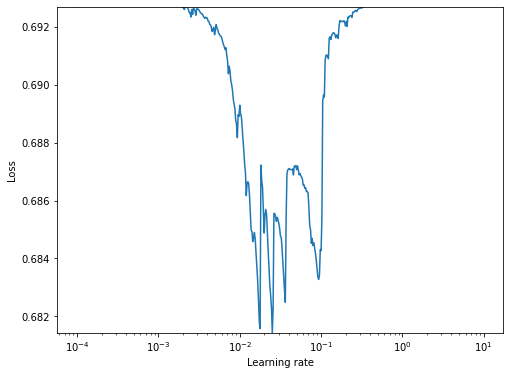

In [12]:
plot_loss_lr(make_model(), X_train, y_train)

After this we update the learning rate of the optimizer inside `make_model` function. Now we can do the grid search.

In [13]:
from sklearn.model_selection import GridSearchCV

keras_clf = keras.wrappers.scikit_learn.KerasClassifier(make_model)

In [14]:
param_grid = {
    'vocab_size': [3000, 6000],
    'embedding_dim': [64, 128],
    'hidden_units': [128],
    'activation': ['relu']
}

grid_search = GridSearchCV(keras_clf, param_grid, cv=2)

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [15]:
%time grid_search.fit(X_train, y_train, epochs=15, callbacks=[early_stop], verbose=0)

391/391 [==============================] - 3s 8ms/step - loss: 0.8604 - accuracy: 0.8379
CPU times: user 49min 52s, sys: 1min 31s, total: 51min 23s
Wall time: 19min 26s


GridSearchCV(cv=2,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7eff009f8970>,
             param_grid={'activation': ['relu'], 'embedding_dim': [64, 128],
                         'hidden_units': [128], 'vocab_size': [3000, 6000]})

In [16]:
grid_search.best_params_

{'activation': 'relu',
 'embedding_dim': 128,
 'hidden_units': 128,
 'vocab_size': 6000}

In [17]:
final_model = make_model(**grid_search.best_params_)

early_stop2 = keras.callbacks.EarlyStopping(patience=6)

In [18]:
%time history = final_model.fit(train_ds, epochs=30, callbacks=[early_stop2], validation_data=val_ds)

Epoch 1/30
782/782 [==============================] - 24s 31ms/step - loss: 0.4240 - accuracy: 0.7999 - val_loss: 0.3018 - val_accuracy: 0.8712
Epoch 2/30
782/782 [==============================] - 24s 31ms/step - loss: 0.2694 - accuracy: 0.8874 - val_loss: 0.3225 - val_accuracy: 0.8643
Epoch 3/30
782/782 [==============================] - 24s 31ms/step - loss: 0.2450 - accuracy: 0.8994 - val_loss: 0.3239 - val_accuracy: 0.8651
Epoch 4/30
782/782 [==============================] - 24s 31ms/step - loss: 0.1996 - accuracy: 0.9144 - val_loss: 0.3803 - val_accuracy: 0.8638
Epoch 5/30
782/782 [==============================] - 24s 31ms/step - loss: 0.2164 - accuracy: 0.9140 - val_loss: 0.3705 - val_accuracy: 0.8579
Epoch 6/30
782/782 [==============================] - 24s 31ms/step - loss: 0.1755 - accuracy: 0.9246 - val_loss: 0.4115 - val_accuracy: 0.8549
Epoch 7/30
782/782 [==============================] - 25s 31ms/step - loss: 0.1539 - accuracy: 0.9308 - val_loss: 0.4403 - val_accuracy:

In [19]:
final_model.evaluate(test_ds)

313/313 [==============================] - 3s 8ms/step - loss: 0.4230 - accuracy: 0.8561


[0.4229743778705597, 0.8561000227928162]

**So the model reached pretty decent accuracy, but it maybe could do better. What could be done more are: profiling, wider grid searching and making every model using only Dataset objects during training and evaluation.**